<a href="https://colab.research.google.com/github/shivang1234gupta/CelebrityProfiling/blob/master/Fameclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import pandas as pd
y=pd.read_csv('drive/My Drive/Random/Output.csv')

In [4]:
corpus=[]
from sklearn.externals import joblib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [5]:
corpus = joblib.load('drive/My Drive/Random/cleaned (1).pkl') 

In [6]:
len(corpus)

14499

In [7]:
from tensorflow.keras.preprocessing.text import one_hot

In [8]:
voc_size=10000
one_hot_rep=[ one_hot(word ,voc_size) for word in corpus ]

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM,Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout

In [10]:
sent_len=500
embedded_docs=pad_sequences(sequences=one_hot_rep,maxlen=sent_len,padding='pre')

In [11]:
embedding_vector_feature=32
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_feature,input_length=sent_len))
model.add(Dropout(.5))
model.add(LSTM(embedding_vector_feature,dropout=.5,recurrent_dropout=.5))
model.add(Dense(embedding_vector_feature,activation='relu'))
model.add(Dropout(.5))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=.00005),metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           320000    
_________________________________________________________________
dropout (Dropout)            (None, 500, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 329,475
Trainable params: 329,475
Non-trainable params: 0
__________________________________________________

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y['fame'] = le.fit_transform(y['fame'])
y['fame'].shape

(14499,)

In [13]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y['fame'])

In [14]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X_final,y_final,random_state=40,test_size=.2)
y_train = tf.keras.utils.to_categorical(y_train, 3)
y_test =  tf.keras.utils.to_categorical(y_test, 3)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop= EarlyStopping(monitor='val_loss',mode='min',patience=3,verbose=1)

In [16]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=64,epochs=40,callbacks=[early_stop])

Epoch 1/40
182/182 [==============================] - 113s 622ms/step - loss: 1.0847 - accuracy: 0.5354 - val_loss: 1.0500 - val_accuracy: 0.7500
Epoch 2/40
182/182 [==============================] - 114s 624ms/step - loss: 0.8720 - accuracy: 0.7376 - val_loss: 0.6854 - val_accuracy: 0.7500
Epoch 3/40
182/182 [==============================] - 114s 627ms/step - loss: 0.7269 - accuracy: 0.7421 - val_loss: 0.6857 - val_accuracy: 0.7500
Epoch 4/40
182/182 [==============================] - 114s 627ms/step - loss: 0.7271 - accuracy: 0.7438 - val_loss: 0.6856 - val_accuracy: 0.7500
Epoch 5/40
182/182 [==============================] - 114s 628ms/step - loss: 0.7204 - accuracy: 0.7468 - val_loss: 0.6867 - val_accuracy: 0.7500
Epoch 00005: early stopping


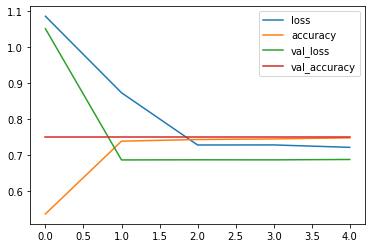

In [17]:
model_loss=pd.DataFrame(model.history.history)
model_loss.plot() 

In [18]:
predictions=model.predict_classes(X_test)
print(predictions.max)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
<built-in method max of numpy.ndarray object at 0x7f5d929ba210>


In [19]:
from sklearn.metrics import f1_score
rounded_labels=np.argmax(y_test, axis=1)
score=f1_score(rounded_labels,predictions,average='weighted')
print(score)

0.6428571428571428


In [20]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

91/91 [==============================] - 4s 49ms/step - loss: 0.6867 - accuracy: 0.7500
Test set
  Loss: 0.687
  Accuracy: 0.750
